In [1]:
import time
import pickle
import numpy as np
import csv
import math
from matplotlib import pyplot as plt

In [2]:
train_list = list(filter(lambda x: (str(x)[-1] in ['1', '5']), range(1, 201)))
test_list = list(filter(lambda x: (str(x)[-1] not in ['1', '5']), range(1, 201)))
low_result = [98, 154, 184]
not_align = [73, 74, 76, 193]

In [3]:
def getLineFromAnnot(time, piece, data='data'):
    with open('/home/mshan/ttemp/{}/timeAnnot/p{}.timeannot.csv'.format(data, piece)) as csvfile:
        reader = csv.reader(csvfile)
        last_row = []
        for row in reader:
            if float(row[1]) <= time and float(row[2]) > time:
                page = int(row[0].split('L')[0][1:])
                line_on_page = int(row[0].split('L')[1])
                return page, line_on_page
            last_row = row
        page = int(last_row[0].split('L')[0][1:])
        line_on_page = int(last_row[0].split('L')[1])
        return page, line_on_page

In [4]:
def getPixel(page, line_on_page, piece):
    with open('/home/mshan/ttemp/data/lineAnnot/p{}.lineinfo.csv'.format(piece)) as csvfile:
        reader = csv.reader(csvfile)
        rows = []
        for row in reader:
            if row[0] == 'P{}L{}'.format(page, line_on_page):
                return int(row[1]), int(row[2])
        return -1, -1

In [5]:
def getPrevNext(piece, page, line_on_page):
    if line_on_page == 1:
        prev_end = 0
        prev_page = -1
    else:
        prev_page = page
        _, prev_end = getPixel(page, line_on_page - 1, piece)
    if getPixel(page, line_on_page + 1, piece)[0] == -1:
        next_start = np.inf
        next_page = -1
    else:
        next_page = page
        _, next_start = getPixel(next_page, line_on_page + 1, piece)
    return prev_end, prev_page, next_start, next_page

In [6]:
def getChangeLineInfo(piece, data='data'):
    # For scoring collars
    with open('/home/mshan/ttemp/{}/timeAnnot/p{}.timeannot.csv'.format(data, piece)) as csvfile:
        reader = csv.reader(csvfile)
        change_line_time = []
        for row in reader:
            change_line_time.append(float(row[-1]))
    return change_line_time[:-1]

In [7]:
def getBoundaryElements(piece, loc):
    '''
    Variable loc could be either 'F' or 'L'.
    Get all elements that are first or last element of a single line, given a piece number.
    '''
    first = []
    last = []
    with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece), 'rb') as f:
        d = pickle.load(f)
        for i in range(1, len(d['events'])):
            
            # check if on the same page as the previous event
            if d['events'][i][2] != d['events'][i-1][2]:
                first.append(i)
                
        for i in range(0, len(d['events'])-1):
            # check if on the same page as the next event
            if d['events'][i][2] != d['events'][i+1][2]:
                last.append(i)
                
    if loc == 'F':
        return [0] + first # 0 is also a first element
    return last + [len(d['events']) - 1] # add the last element of a piece

In [78]:
def accuracy(time, piece, events, data='data', white=0, collar=0, sys='subseqDTW', pred_lines=None, wp=None):
    accu_time = 0
    total_time = time[-1] - time[0]
    tol = 100
    if sys == 'hierarchicalDTW':
        bounds = getBoundaryElements(piece, "F")
    # for visualization
    accu_info = []
    change_line_info = []
    prev_line = 0
    
    for i in range(len(time)-1):
        is_accurate = False
        time_point = time[i]
        print(time_point)
        page, line_on_page = getLineFromAnnot(time_point, piece, data)
        start, end = getPixel(page, line_on_page, piece)
        prev_end, prev_page, next_start, next_page = getPrevNext(piece, page, line_on_page)
        # for visualization
        if line_on_page == prev_line:
            change_line_info.append('c')
        else:
            change_line_info.append('f')
        prev_line = line_on_page
        
        # Check if this prediction is correct
        change_line_list = np.asarray(getChangeLineInfo(piece, data))
        beginInCollar = sum(abs(change_line_list - time[i]) <= collar)
        endInCollar = sum(abs(change_line_list - time[i+1]) <= collar)
        if beginInCollar > 0 and endInCollar > 0:
            total_time -= time[i+1]-time[i]
            accu_info.append('c')
            is_accurate = True
         
        else:
            if sys == 'hierarchicalDTW':
                start_idx = bounds[pred_lines[i]]
                start_event = events[start_idx]
            else:
                start_event = events[wp[i][1]]
            if start_event[5] == page - white:
                cur_start = start_event[3]
                cur_end = start_event[4]
                if cur_start < start+tol and cur_end > end-tol:
                    if (page != prev_page or cur_start > prev_end + tol) and (page != next_page or cur_end < next_start - tol):
                        accu_time += time[i+1]-time[i]
                        accu_info.append('c')
                        is_accurate = True
                if not is_accurate:
                    print(cur_start, cur_end, start, end)
                
        if not is_accurate:
            accu_info.append('w')
            
    return accu_time/total_time, accu_info, change_line_info

In [79]:
def runBenchmark(data='data', tol=100, collar=0, alpha=0, verbose=True, sys='subseqDTW'):
    acc_list = []
    for i in [185]:
        if i not in low_result:
            white = 0
            if i in [4, 6, 7, 8, 14, 29, 30, 31, 32, 48, 53, 54, 59, 62, 98, 124, 136, 140, 150, 191, 199]:
                white = 1
            if i in [133, 138]:
                white = 2
            
            if sys == 'hierarchicalDTW':
                pklfile = '/home/mshan/ttemp/data/hyp/{}/{}/{}/p{}.pkl'.format(sys, data, alpha, i)
                with open(pklfile, 'rb') as f:
                    d = pickle.load(f)
                acc, _, change_line_info = accuracy(d['actual_time'], i, d['events'], sys=sys, data=data, white=white, collar=collar, pred_lines=d['pred_lines'])
            else:
                pklfile = '/home/mshan/ttemp/data/hyp/{}/{}/p{}.pkl'.format(sys, data, i)
                with open(pklfile, 'rb') as f:
                    d = pickle.load(f)
                acc, _, change_line_info = accuracy(d['actual_time'], i, d['events'], sys=sys, data=data, white=white, collar=collar, wp=d['wp'])
            if math.isnan(acc):
                acc = 0
            acc_list.append(acc)
            
            if verbose:
                print("Accuracy is {} for piece {}.".format(acc, i))
    return acc_list, change_line_info

In [80]:
import time
start = time.time()
acc_list, change_line_info = runBenchmark(data='data', alpha=0.5, verbose=True, sys='hierarchicalDTW')
print("Average accuracy is: {}".format(sum(acc_list)/len(acc_list)))
print("Average time is: {}".format((time.time()-start)/len(acc_list)))

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
990.0 1314.677966101694 501 803
7.5
990.0 1314.677966101694 501 803
7.6000000000000005
990.0 1314.677966101694 501 803
7.7
990.0 1314.677966101694 501 803
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.

72.10000000000001
72.2
72.3
72.4
72.5
72.60000000000001
72.7
72.8
72.9
73.0
73.10000000000001
73.2
73.3
73.4
73.5
73.60000000000001
73.7
73.8
73.9
74.0
74.10000000000001
74.2
74.3
74.4
74.5
74.60000000000001
74.7
74.8
74.9
75.0
75.10000000000001
75.2
75.3
75.4
75.5
75.60000000000001
75.7
75.8
75.9
76.0
76.10000000000001
76.2
76.3
76.4
76.5
76.60000000000001
76.7
76.80000000000001
76.9
77.0
77.10000000000001
77.2
77.30000000000001
77.4
77.5
77.60000000000001
77.7
77.80000000000001
77.9
78.0
78.10000000000001
78.2
78.30000000000001
78.4
78.5
78.60000000000001
78.7
878.0 1193.8749999999995 336 655
78.80000000000001
878.0 1193.8749999999995 336 655
78.9
878.0 1193.8749999999995 336 655
79.0
878.0 1193.8749999999995 336 655
79.10000000000001
878.0 1193.8749999999995 336 655
79.2
878.0 1193.8749999999995 1469 1793
79.30000000000001
878.0 1193.8749999999995 1469 1793
79.4
878.0 1193.8749999999995 1469 1793
79.5
878.0 1193.8749999999995 1469 1793
79.60000000000001
878.0 1193.8749999999995 1469

108.4
108.5
108.60000000000001
108.7
108.80000000000001
108.9
109.0
109.10000000000001
109.2
109.30000000000001
109.4
109.5
660.0 1142.9811320754707 314 737
109.60000000000001
660.0 1142.9811320754707 314 737
109.7
660.0 1142.9811320754707 314 737
109.80000000000001
660.0 1142.9811320754707 314 737
109.9
660.0 1142.9811320754707 314 737
110.0
660.0 1142.9811320754707 314 737
110.10000000000001
660.0 1142.9811320754707 314 737
110.2
660.0 1142.9811320754707 314 737
110.30000000000001
660.0 1142.9811320754707 314 737
110.4
660.0 1142.9811320754707 314 737
110.5
660.0 1142.9811320754707 314 737
110.60000000000001
660.0 1142.9811320754707 314 737
110.7
660.0 1142.9811320754707 314 737
110.80000000000001
660.0 1142.9811320754707 314 737
110.9
660.0 1142.9811320754707 314 737
111.0
660.0 1142.9811320754707 314 737
111.10000000000001
660.0 1142.9811320754707 314 737
111.2
660.0 1142.9811320754707 314 737
111.30000000000001
660.0 1142.9811320754707 314 737
111.4
660.0 1142.9811320754707 314 73

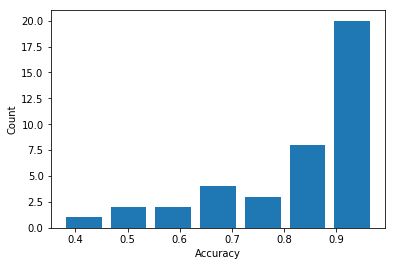

In [13]:
plt.hist(acc_list, bins='auto', rwidth=0.8)
plt.ylabel('Count');
plt.xlabel('Accuracy');

In [ ]:
#for alpha in [0, 0.01, 0.1, 0.2, 0.5, 1, -0.01, -0.1, -0.5]:
for collar in [0, 0.1, 0.2, 0.5, 1]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        acc_list, change_line_info = runBenchmark(data=data, collar=collar, verbose=False, sys='subseqDTW')
        print("Average accuracy is: {} for data {} and alpha {}.".format(sum(acc_list)/len(acc_list), data, collar))

In [38]:
for collar in [0, 0.1, 0.2, 0.5, 1]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        acc_list, change_line_info = runBenchmark(data=data, collar=collar, verbose=False, sys='jumpDTW')
        print("Average accuracy is: {} for data {} and alpha {}.".format(sum(acc_list)/len(acc_list), data, collar))

Average accuracy is: 0.7512044167283731 for data data and alpha 0.
Average accuracy is: 0.7276053777330892 for data data_repeat1 and alpha 0.
Average accuracy is: 0.735410647590413 for data data_repeat2 and alpha 0.
Average accuracy is: 0.7416027676857653 for data data_repeat3 and alpha 0.
Average accuracy is: 0.7343309287713479 for data data_dsalfine and alpha 0.
Average accuracy is: 0.7530893203695038 for data data and alpha 0.1.
Average accuracy is: 0.7295160041123226 for data data_repeat1 and alpha 0.1.
Average accuracy is: 0.7372679602667704 for data data_repeat2 and alpha 0.1.
Average accuracy is: 0.7435272366762428 for data data_repeat3 and alpha 0.1.
Average accuracy is: 0.736277974558858 for data data_dsalfine and alpha 0.1.
Average accuracy is: 0.7606985990412641 for data data and alpha 0.2.
Average accuracy is: 0.736573427441893 for data data_repeat1 and alpha 0.2.
Average accuracy is: 0.744304060489507 for data data_repeat2 and alpha 0.2.
Average accuracy is: 0.750893349154

In [16]:
#for alpha in [0, 0.01, 0.1, 0.2, 0.5, 0.6, 1, -0.01, -0.1, -0.2]:
for alpha in [0.6]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        acc_list, change_line_info = runBenchmark(data=data, alpha=alpha, collar=0.2, verbose=False, sys='hierarchicalDTW')
        print("Average accuracy is: {} for data {} and alpha {}.".format(sum(acc_list)/len(acc_list), data, alpha))

Average accuracy is: 0.8401589175356747 for data data and alpha 0.6.
Average accuracy is: 0.7934093484997595 for data data_repeat1 and alpha 0.6.
Average accuracy is: 0.786855424338881 for data data_repeat2 and alpha 0.6.
Average accuracy is: 0.7824658967159788 for data data_repeat3 and alpha 0.6.
Average accuracy is: 0.7818593570381913 for data data_dsalfine and alpha 0.6.


### Debug

In [37]:
def calDistInfo(i, data='data'):
    with open('/home/mshan/ttemp/data/hyp/subseqDTW/{}/p{}.pkl'.format(data, i), 'rb') as f:
        d = pickle.load(f)
    acc, acc_info, change_info = accuracy(d['actual_time'], d['wp'], i, d['events'], data=data, white=0)
    time_list = [(d['actual_time'][i], d['actual_time'][i+1]) for i in range(len(d['actual_time'])-1)]
    return time_list, acc_info, change_info

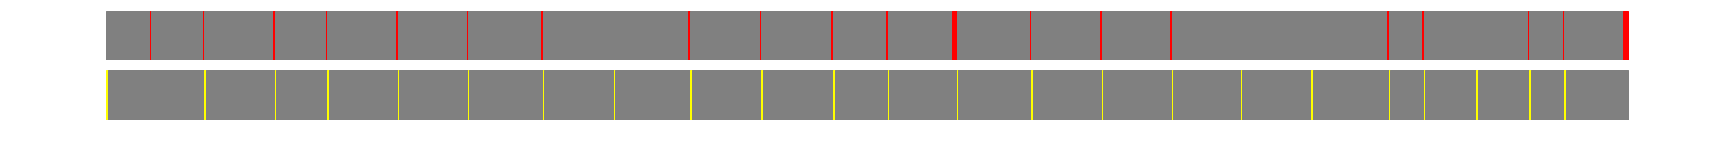

In [38]:
color = {}
color['c'] = 'gray'
color['w'] = 'red'
color['f'] = 'yellow'

time_list, acc_info, change_info = calDistInfo(1)

fig, axs = plt.subplots(2, figsize=(30,2))
axs[0].axis('off')
axs[1].axis('off')
for idx, time in enumerate(time_list):
    axs[0].axvspan(float(time[0]), float(time[1]), color=color[acc_info[idx]])
    axs[1].axvspan(float(time[0]), float(time[1]), color=color[change_info[idx]])

In [91]:
with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(131), 'rb') as f:
    d = pickle.load(f)
    events = d['events']
with open('/home/mshan/ttemp/data/hyp/hierarchicalDTW/{}/{}/p{}.pkl'.format('data_dsalfine', 0.5, 131), 'rb') as f:
    d = pickle.load(f)
    times = d['actual_time']
    lines = d['pred_lines']

In [92]:
bounds = getBoundaryElements(131, "F")
prev_line = -1
for idx, line in enumerate(lines):
    if line != prev_line:
        start_idx = bounds[line]
        start_event = events[start_idx]
        print("P{}L{} starts at {}.".format(start_event[5], start_event[2]+1, times[idx]))
    prev_line = line

P12L4 starts at 0.0.
P3L4 starts at 0.30000000000000004.
P4L1 starts at 6.5.
P4L2 starts at 14.200000000000001.
P4L3 starts at 19.400000000000002.
P4L4 starts at 24.400000000000002.
P4L5 starts at 33.1.
P4L2 starts at 39.0.
P4L3 starts at 42.6.
P4L4 starts at 49.300000000000004.
P4L5 starts at 57.300000000000004.
P4L3 starts at 61.800000000000004.
P4L4 starts at 66.8.
P4L5 starts at 71.60000000000001.
P5L1 starts at 82.4.
P5L2 starts at 86.9.
P5L3 starts at 94.10000000000001.
P5L4 starts at 97.0.
P5L5 starts at 100.4.
P6L1 starts at 104.5.
P6L2 starts at 108.0.
P6L3 starts at 110.2.
P6L4 starts at 112.60000000000001.
P6L5 starts at 116.60000000000001.
P7L1 starts at 120.7.
P7L2 starts at 125.7.
P7L3 starts at 128.6.
P7L4 starts at 132.0.
P8L1 starts at 135.3.
P8L2 starts at 137.9.
P8L3 starts at 141.0.
P8L4 starts at 143.9.
P9L1 starts at 149.4.
P9L2 starts at 153.8.
P9L3 starts at 158.4.
P9L4 starts at 162.70000000000002.
P10L1 starts at 167.5.
P10L2 starts at 171.8.
P10L3 starts at 1